## Airline AI Assistant

In [4]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [5]:
load_dotenv(override=True)

api_key= os.getenv('OPENAI_API_KEY')
base_url=os.getenv('OPENAI_BASE_URL')


if api_key and api_key.startswith('helix-') and len(api_key)>10:
    print("API key looks good so far")
else:
    print("There might be a problem with your API key? Please visit the troubleshooting notebook!")

MODEL="gpt-4o-mini"

openai = OpenAI(
    base_url=base_url,
    api_key=api_key
)

API key looks good so far


In [6]:
system_message = "You are a helpful assistant for an Airline called FlightAI."
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [ ]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

## Tools

In [9]:
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [10]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

In [11]:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [12]:
tools = [{"type": "function", "function": price_function}]

## OpenAI use the tool

In [13]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [14]:
def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [ ]:
gr.ChatInterface(fn=chat, type="messages").launch()

In [15]:
import base64
from io import BytesIO
from PIL import Image

In [16]:
def artist(city):
    image_response = openai.images.generate(
        model="FLUX.1-pro",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

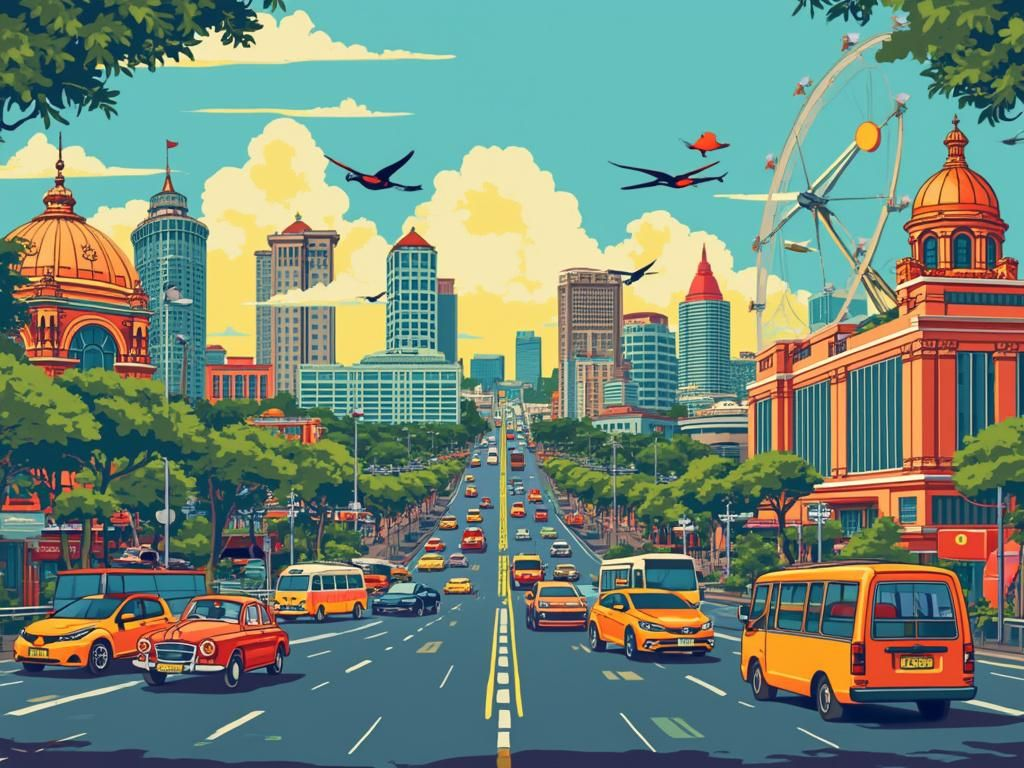

In [17]:
image = artist("Bangalore City")
display(image)

In [18]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
        model="gpt-4o-mini-tts",
        voice="nova", # alloy or onyx
        input=message
    )

    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [19]:
talker("Well, hi there. How are you doing today?")

Input #0, wav, from '/var/folders/yq/wj00tv3164vbkhp8wcwps39c0000gn/T/tmpqcdrte9z.wav':
  Duration: 00:00:02.30, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


## Agent Framework

In [20]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)

    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    talker(reply)
    
    return history, image

In [21]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7879
* To create a public link, set `share=True` in `launch()`.


Input #0, wav, from '/var/folders/yq/wj00tv3164vbkhp8wcwps39c0000gn/T/tmp07_xz82f.wav':
  Duration: 00:00:02.57, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s


Input #0, wav, from '/var/folders/yq/wj00tv3164vbkhp8wcwps39c0000gn/T/tmpnv4amwbh.wav':
  Duration: 00:00:03.55, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s



Tool get_ticket_price called for London


Input #0, wav, from '/var/folders/yq/wj00tv3164vbkhp8wcwps39c0000gn/T/tmp7h8cpwbi.wav':
  Duration: 00:00:03.31, bitrate: 384 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 24000 Hz, 1 channels, s16, 384 kb/s
